In [19]:
appliances = {
        0: {'app': 'kettle', 'power': 2000},
        1: {'app': 'toaster', 'power': 1200},
        2: {'app': 'dish washer', 'power': 2000},
        #diminui em 300 todos eles
        # 3: {'app': 'microwave', 'power':1500}
        # 4: {'app': 'hair dryer', 'power': 1000},
        # 5: {'app': 'audio amplifier', 'power': 20},
    }

#air dryer nao tem na casa 2?
#tirar hair dryer e audio amplifier!!!

# deep_learning_technique = ['ANN']
# deep_learning_technique = ['CNN', 'GRU']
deep_learning_technique = ['ANN', 'CNN', 'GRU']

homes = [1,2,5]

#esse dict soh serve pra dar load na rede
app_to_image_size = {
    'kettle': 48,
    'toaster': 64,
    'audio amplifier': 0,
    'dish washer': 166,
    'hair dryer': 27,
    'microwave': 42
}

In [20]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import nilmtk
from nilmtk import DataSet, MeterGroup
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import seaborn as sns
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

sns.set()
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20, 8)
caminho_ukdale = 'ukdale.h5'

# Lendo Dataset do Ukdale
ukdale = DataSet(caminho_ukdale)

In [21]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

device = torch.device(dev)

In [22]:
import pandas
import nilmtk
from nilmtk import DataSet, MeterGroup
caminho_ukdale = 'ukdale.h5'

# Lendo Dataset do Ukdale
ukdale = DataSet(caminho_ukdale)


elec = ukdale.buildings[1].elec
df = next(elec.mains().load())
df.columns = [' '.join(col).strip() for col in df.columns.values]
df = df.rename(columns={'power apparent': 'pwr_app_mains', 'power active': 'pwr_act_mains', 'voltage': 'voltage_mains'})
df = df.sort_index()
df.head()


,pwr_app_mains,pwr_act_mains,voltage_mains
2013-03-17 19:12:43.100000+00:00,431.040009,337.880005,240.149994
2013-03-17 19:12:44.100000+00:00,427.940002,339.429993,240.559998
2013-03-17 19:12:45.100000+00:00,429.660004,340.630005,241.070007
2013-03-17 19:12:46.100000+00:00,426.989990,338.799988,240.440002
2013-03-17 19:12:47.100000+00:00,429.130005,340.880005,241.009995


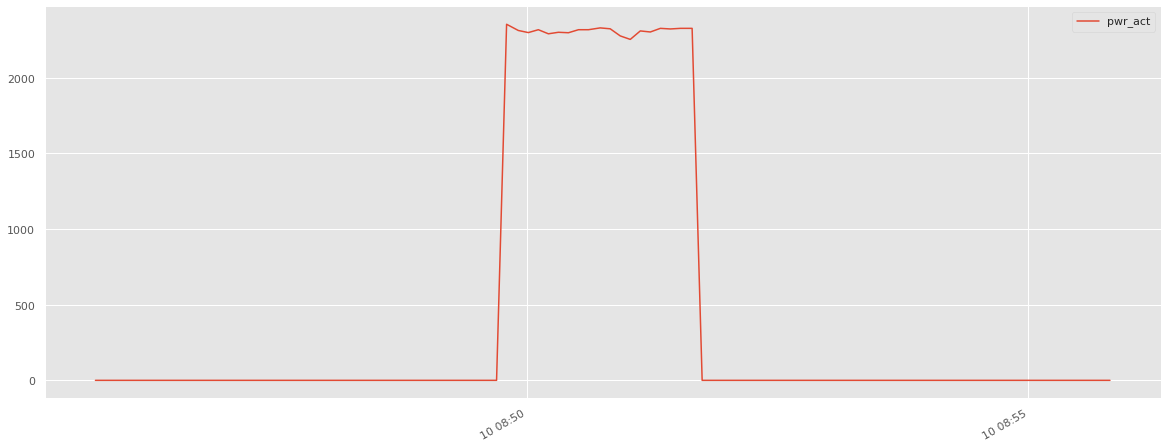

In [23]:
# import matplotlib
kettle = next(elec['kettle'].load())
kettle = kettle.sort_index()
kettle.columns = ['pwr_act']
# kettle['time'] = kettle.index
# kettle['time'] = kettle['time'].apply(lambda x: x.tz_localize(None))

# elec.mains().plot()
kettle[kettle.pwr_act>200]
kettle[6000:6100].plot()

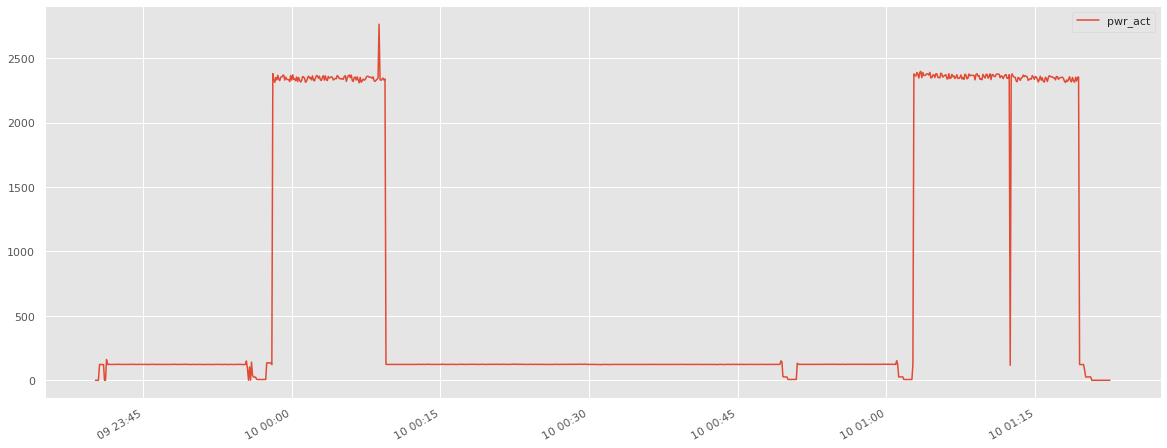

In [24]:
# import matplotlib
dish_washer = next(elec['dish washer'].load())
dish_washer = dish_washer.sort_index()
dish_washer.columns = ['pwr_act']
dish_washer[dish_washer.pwr_act>200]
dish_washer[700:1700].plot()

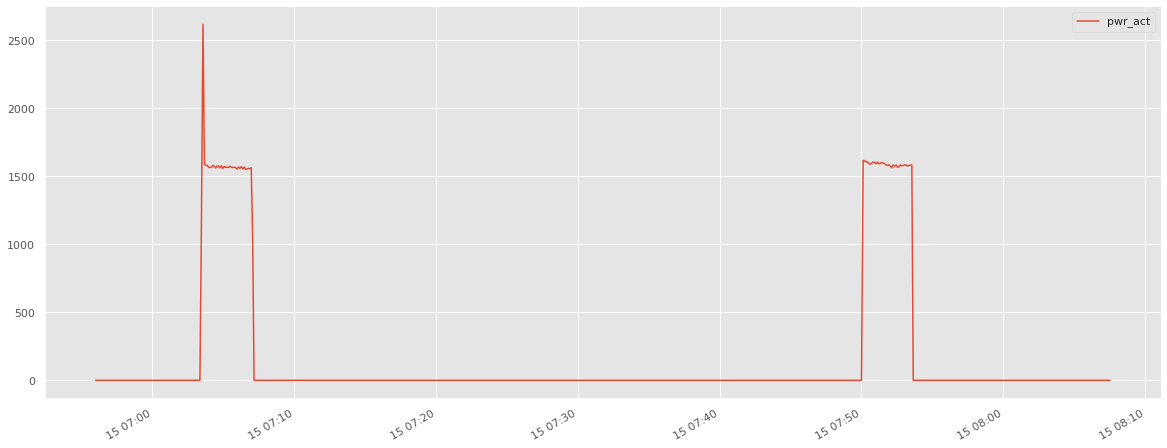

In [25]:
# import matplotlib
toaster = next(elec['toaster'].load())
toaster = toaster.sort_index()
toaster.columns = ['pwr_act']
toaster[toaster.pwr_act>200]
toaster[5000:5700].plot()

In [26]:
class MyDataset(Dataset):
    def __init__(self, data, image_size, target_cols):
        self.data = torch.from_numpy(data).to(device)
        self.image_size = image_size
        self.target_cols = target_cols
        self.shape = self.__getshape__()
        self.size = self.__getsize__()
 
    def __getitem__(self, index):
        x = self.data[index:index+self.image_size, 0:self.target_cols]
        y = self.data[index:index+self.image_size, self.target_cols]
        return x, y
 
    def __len__(self):
        return len(self.data)
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

In [27]:
def create_dataset(ukdale, appliance, power, house):
    # Lendo eletrodomesticos da Casa House
    elec = ukdale.buildings[house].elec

    #Criando dataset do mains
    main_df = next(elec.mains().load())
    # print(main_df.head())
    main_df.columns = [' '.join(col).strip() for col in main_df.columns.values]
    main_df = main_df.rename(columns={'power apparent': 'pwr_app_mains', 'power active': 'pwr_act_mains', 'voltage': 'voltage_mains'})
    main_df = main_df.sort_index()
    
    appliance_df = next(elec[appliance].load())
    appliance_df.columns = ['pwr_act_' + appliance]
    appliance_df = appliance_df.sort_index()
    
    #-------------------Upsample do main_df--------------------------#
    appliance_df = appliance_df[appliance_df.index >= main_df.index[0]]

    main_df = main_df.resample('6S', offset='5s').mean().interpolate()
    main_df = main_df[main_df.index >= main_df.index[1]]
    main_df = main_df[main_df.index <= appliance_df.index[-1]]

    #------------------Resampling appliance_df-----------------------#
    appliance_df = appliance_df.resample('6S', offset='5s').mean().interpolate()

    #-------------------Merging dataframes---------------------------#
    merged_df = main_df.merge(appliance_df, left_index=True, right_index=True)
    merged_df['time'] = merged_df.index
    merged_df['time'] = merged_df['time'].apply(lambda x: x.tz_localize(None))
    merged_df.index = merged_df['time']
    merged_df['dia_semana'] = merged_df.time.dt.dayofweek
    merged_df['mes'] = merged_df.time.dt.month
    merged_df['hora'] = merged_df.time.dt.hour
    merged_df = merged_df.drop(columns=['time'])

    #---------------Criando coluna classificatoria-------------------#
    merged_df['ligado'] = merged_df['pwr_act_' + appliance] > power
    
    return merged_df

In [28]:
def separate_training_from_test(df):
    #Fazendo a divisao entre treino e teste de forma que 1 milhao de pontos sejam utilizados para treinar
    train_test_divide = df.index[int(0.8*len(df))]

    print("inicio treino: " + str(df.index[0]))
    print("final treino: " + str(train_test_divide))
    print("final teste: " + str(df.index[-1]))
    
    train = df[df.index <= train_test_divide]
    test = df[df.index > train_test_divide]
    
    return train,test

In [29]:
def calculate_batch_size(df):
    df["ligado"] = df["ligado"].astype(int)
    df_ligado = df[df['ligado'] == True][['ligado']].reset_index()
    df_ligado['diferenca'] = df_ligado['time'].diff()
    df_ligado[df_ligado['diferenca'] > '00:00:30']
    
    
    # add a column saying if a row belongs to the same state as the one before it
    df_ligado["is_first"] = df_ligado['diferenca'] > "00:00:06"

    # the cumulative sum - each "clump" gets its own integer id
    df_ligado["value_group"] = df_ligado["is_first"].cumsum()

    # get the rows corresponding to states beginning
    start = df_ligado.groupby("value_group", as_index=False).nth(0)
    # get the rows corresponding to states ending
    end = df_ligado.groupby("value_group", as_index=False).nth(-1)

    start_end = pd.DataFrame(
        {
            "start": start.index,
            # add freq to get when the state ended
            "end": end.index,
        }
    )
    # convert timedeltas to seconds (float)
    start_end["duration"] = (
        (start_end["end"] - start_end["start"]).apply(np.int64)
    )

    biggest_window = max(start_end.duration)
    return biggest_window

In [30]:
def create_sequential_dataset(df,  image_size, batch_size, target_cols):
    df = df[['voltage_mains', 'pwr_app_mains', 'pwr_act_mains', 'dia_semana', 'hora', 'ligado']]
    df_scaled = pd.DataFrame(np.append(
        preprocessing.scale(df[['voltage_mains', 'pwr_app_mains', 'pwr_act_mains', 'dia_semana', 'hora']]), df[['ligado']].values, axis=1),
                                index=df.index, columns=df.columns)
    dataset = MyDataset(df_scaled.values, image_size, target_cols)
    dfloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size)
    return dfloader

In [31]:
def choose_net(dp_tec,  image_size, batch_size):
    n=5
    if dp_tec == 'ANN':
        class Net(nn.Module):    
            def __init__(self):
                super(Net, self).__init__()
                self.hd1 = nn.Linear(image_size*n, 500*n)
                self.hd2 = nn.Linear(500*n, 500*n)
                self.hd3 = nn.Linear(500*n, 500*n)
                self.hd4 = nn.Linear(500*n, image_size)
                # self.bn = nn.BatchNorm1d(500*n)
                self.bn = nn.BatchNorm1d(image_size)
                self.dropout = nn.Dropout(p=0.5)

            def forward(self, x):
                x = F.relu(self.hd1(x.reshape(x.size(0), -1)))
                x = F.relu(self.hd2(x))
                x = F.relu(self.hd3(x))
                x = self.hd4(x)
                x = self.bn(x)
                x = self.dropout(x)
                return x

        def init_weights(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
        net = Net()

    if dp_tec == 'CNN':            
        class Net(nn.Module):    
            def __init__(self):
                super(Net, self).__init__()
                self.pool1 = nn.MaxPool1d(5,1)
                self.cv1 = nn.Conv1d(n, n*8, 3)
                self.cv2 = nn.Conv1d(n*8, n*8, 3)
                self.cv3 = nn.Conv1d(n*8, 16*n, 3)
                self.cv4 = nn.Conv1d(16*n, 16*n, 3)
                self.cv5 = nn.Conv1d(16*n, 32*n, 3)       
                self.cv6 = nn.Conv1d(32*n, 32*n, 3)
                self.cv7 = nn.Conv1d(32*n, 64*n, 3)
                self.cv8 = nn.Conv1d(64*n, 64*n, 3)
                self.fc1 = nn.Linear(64*n*(image_size - 40), 300)
                self.fc2 = nn.Linear(300, image_size)
                self.bn = nn.BatchNorm1d(64*n)
                self.dropout = nn.Dropout(p=0.75)

            def forward(self, x):
                x = F.relu(self.cv2(F.relu(self.cv2(F.relu(self.cv1(x))))))
                x = self.pool1(x)
                x = F.relu(self.cv4(F.relu(self.cv4(F.relu(self.cv3(x))))))
                x = self.pool1(x)
                x = F.relu(self.cv6(F.relu(self.cv6(F.relu(self.cv5(x))))))
                x = self.pool1(x)
                x = F.relu(self.cv8(F.relu(self.cv8(F.relu(self.cv7(x))))))
                x = self.bn(x)
                x = self.pool1(x)
                x = F.relu(self.fc1(x.reshape(x.size(0), -1)))
                x = self.dropout(x)
                x = self.fc2(x)
                return x
        def init_weights(m):
            if type(m) == nn.Conv1d or type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01) 
        net = Net()


    if dp_tec == 'GRU':
        class EncoderRNN(nn.Module):
            def __init__(self):
                super(EncoderRNN, self).__init__()
                self.cv1 = nn.Conv1d(n, n*8, 3)
                self.gru1 = nn.GRU(40, 128, num_layers = 2, bidirectional = True, batch_first = True)
                self.fc1 = nn.Linear(256, 100)
                self.fc2 = nn.Linear(100, image_size)
                self.bn = nn.BatchNorm1d(image_size-2)
                self.dropout = nn.Dropout(p=0.6)

            def forward(self, x, hidden):
                x = torch.transpose(x, 1, 2)
                x = F.relu(self.cv1(x))
                x = torch.transpose(x, 1, 2)        
                x, hidden = self.gru1(x, hidden)
                x = self.bn(x)
                x = F.relu(self.fc1(F.relu(x[:,-1])))
                x = self.dropout(x)
                x = self.fc2(x)
                return x, hidden
            def initHidden(self):
                return torch.zeros(4, batch_size, 128, device=device)
        def init_weights(m):
            if type(m) == nn.Conv1d or type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
            if type(m) == nn.GRU:
                for layer_p in m._all_weights:
                    for p in layer_p:
                        if 'weight' in p:
                            #print(p, m.__getattr__(p))
                            torch.nn.init.xavier_uniform_(m.__getattr__(p))
                        if 'bias' in p:
                            m.__getattr__(p).data.fill_(0.01)
        def repackage_hidden(h):
            """Wraps hidden states in new Tensors, to detach them from their history."""
            if isinstance(h, torch.Tensor):
                return h.detach()
            else:
                return tuple(repackage_hidden(v) for v in h)
        net = EncoderRNN()

    #inicializacao
    net = net.to(device)
    net.apply(init_weights)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.zero_grad()
    
    return net, criterion, optimizer

In [32]:
def train_net(net, trainloader, optimizer, criterion, appliance, dp_tec, image_size):
    comeco = datetime.datetime.now()
    print('###########################')
    print('Comeco do treino para ', appliance, ' utilizando a rede ', dp_tec, ' inicio as ', comeco)
    if dp_tec == 'GRU':
        net.train()
    # for epoch in range(1):
    for epoch in range(5):  # loop over the dataset multiple times
        hidden = False
        real_i = 0
        running_loss = 0.0
        if dp_tec == 'GRU':
            hidden = net.initHidden()
        for i, data in enumerate(trainloader, 0):
            if i > len(trainloader)-image_size:
                break
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            labels = labels.to(device)
            if torch.max(labels).item() == 0:
                continue     
            optimizer.zero_grad()

            if dp_tec == 'CNN':
                inputs = torch.transpose(inputs,1,2)
            if dp_tec == 'GRU':
                    hidden = hidden.data
                    net.zero_grad()
                    outputs, hidden = net(inputs.float(), hidden)
            else:
                # forward + backward + optimizepadded input size per channel: 
                outputs = net(inputs.float())

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            real_i += 1

            # print statistics
            running_loss += loss.item()
            if real_i % 100 == 99:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, real_i + 1, running_loss / 100))
                running_loss = 0.0

    duracao = datetime.datetime.now() - comeco
    print('Finished Training ', dp_tec, ' para ', appliance, ' com duracao de ', duracao)
    print('terminou as ', datetime.datetime.now())
    net.eval()
    return net, hidden

In [33]:
def save_net(net, appliance, dp_tec):  
    onde_salvar_rede = 'BCEwithlogits_'
    nome_appliance = appliance.replace(' ', '_')
    onde_salvar_rede = onde_salvar_rede + dp_tec + '_' + nome_appliance + '_sigmoid.pt'

    
    torch.save(net.state_dict(), onde_salvar_rede)
    print('rede salva com sucesso em:')
    print(onde_salvar_rede)

In [34]:
def load_net(path, dp_tec, appliance, image_size, batch_size):
    image_size = app_to_image_size[appliance]
    net,_,_ = choose_net(dp_tec, image_size, batch_size)
    # net = torch.load(path, map_location=device)
    net.load_state_dict(torch.load(path))
    print(net.eval())
    return net

In [35]:
def print_start_test(appliance, dp_tec, house, is_test=False):
    comeco = datetime.datetime.now()
    print("-----------------------------")
    if is_test == True:
        print('comeco do teste para ', appliance, 'utilizando ', dp_tec, 'foi as', comeco)
    else:
        print('comeco da validacao para casa', str(house), 'do ', appliance, 'utilizando ', dp_tec, 'foi as', comeco)


def test_net(net, dfloader, dp_tec, image_size, hidden = False):
    comeco_teste = datetime.datetime.now()
    print(net.eval())
    array_results = []

    for i, data in enumerate(dfloader, 0):

        if i > len(dfloader)-image_size:
            break

        if i % 10000 == 9999:
            print(i + 1)
            print(datetime.datetime.now() - comeco_teste)

        inputs, _ = data
        if dp_tec == 'CNN':
            inputs = torch.transpose(inputs,1,2)
        if dp_tec == 'GRU':
            hidden = hidden.data
            out, hidden = net(inputs.float(), hidden)
        else:
            out = net(inputs.float())

        for element in out:
            array_results.append(element.detach().cpu().numpy())

    duracao = datetime.datetime.now() - comeco_teste
    print('duracao do teste:', duracao)
    print("-----------------------------")
    return array_results

def out_into_df(df, out, image_size):
    df['saidas'] = 0.0
    array = df.loc[:, 'saidas'].values

    for i, element in enumerate(out):
        array[i:i+image_size] += element
    # array=array/image_size    
    df.loc[:, ('saidas')] = array/image_size
    return df

def save_df_into_csv(df, dp_tec, appliance, house, is_test=False):
    if is_test == True:
        nome_arquivo = 'saida_teste_'

    else:
        nome_arquivo = 'saida_casa_' + str(house) + '_'

    nome_appliance = appliance.replace(' ', '_')
    nome_arquivo = nome_arquivo + dp_tec + '_' + nome_appliance + '_sigmoid.csv'

    

    df.to_csv(nome_arquivo, sep=',', header=True, index=True)
    return True

def open_csv_as_df(dp_tec, appliance, house, is_test=False):
    if is_test == True:
        nome_arquivo = 'saida_teste_'
    else:
        nome_arquivo = 'saida_casa_' + str(house) + '_'
    nome_appliance = appliance.replace(' ', '_')
    nome_arquivo = 'results/'+nome_arquivo + dp_tec + '_' + nome_appliance + '.csv'
    df = pd.read_csv(nome_arquivo, sep=',')
    return df

In [36]:
comeco_total = datetime.datetime.now()
print('comecou as ', comeco_total)

for i in appliances:
    comeco_aparelho = datetime.datetime.now()
    
    ukdale = DataSet(caminho_ukdale)

    #Escolha se deseja escolher uma janela de tempo e o período de inicio e fim:    
    set_timewindow = True
    startDate = '2013-03-01'
    endDate = '2013-09-01'
    
    #Escolha do eletrodomestico:
    appliance = appliances[i]['app']
    power = appliances[i]['power']
    
    if set_timewindow:
        ukdale.set_window(start=startDate, end=endDate)
    
    print('Comeco do aparelho ', appliance , ' foi as ', comeco_aparelho)
    #create Dataset
    df = create_dataset(ukdale, appliance, power, 1)
    
    #Desagregacao
    train,test = separate_training_from_test(df)

    #Batch Size
    biggest_window = calculate_batch_size(train)

    #Criando Dataset sequencial
    image_size = biggest_window + 2
    if image_size < 41:
        image_size = 42
    batch_size = 64
    target_cols = 5
    
    trainloader = create_sequential_dataset(train, image_size, batch_size, target_cols)
    
    #pro futuro:
    print(appliance, ' image_size =', image_size)
    
    ####running all for all appliances#####
    for dp_tec in deep_learning_technique:
        
        #training
        torch.cuda.empty_cache()
        net, criterion, optimizer = choose_net(dp_tec, image_size, batch_size)
        net.eval()
        net, hidden = train_net(net, trainloader, optimizer, criterion, appliance, dp_tec, image_size)
        save_net(net, appliance, dp_tec)

        #testing
        torch.cuda.empty_cache()
        print_start_test(appliance, dp_tec, 1, is_test=True)
        testloader = create_sequential_dataset(test, image_size, batch_size, target_cols)
        out = test_net(net, testloader, dp_tec, image_size, hidden=hidden)
        test = out_into_df(test, out, image_size)
        save_df_into_csv(test,   dp_tec, appliance, 1, is_test=True)

        # resultados em casas nao vistas
        for house in homes:
            torch.cuda.empty_cache()
            if house == 1:
                set_timewindow = True
                startDate = '2013-09-01'
                endDate = '2015-05-01'
            else:
                set_timewindow = False
            ukdale = DataSet(caminho_ukdale)
            if set_timewindow:
                ukdale.set_window(start=startDate, end=endDate)
            if house == 2 and appliance=='air dryer':
                pass
            df = create_dataset(ukdale, appliance, power, house)
            net.eval()

            print_start_test(appliance, dp_tec, house)
            dfloader = create_sequential_dataset(df, image_size, batch_size, target_cols)
            out = test_net(net, dfloader, dp_tec, image_size, hidden=hidden)
            df = out_into_df(df, out, image_size)
            save_df_into_csv(df, dp_tec, appliance, house)
        
    print('fim do aparelho ', appliance, 'as ', datetime.datetime.now())
    print('duracao de ', datetime.datetime.now() - comeco_aparelho)

comecou as  2023-07-04 00:15:49.646293
Comeco do aparelho  kettle  foi as  2023-07-04 00:15:49.646734
inicio treino: 2013-03-17 19:12:47
final treino: 2013-07-29 13:38:29
final teste: 2013-08-31 23:59:53


/tmp/ipykernel_4677/3504317227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ligado"] = df["ligado"].astype(int)


kettle  image_size = 48
###########################
Comeco do treino para  kettle  utilizando a rede  ANN  inicio as  2023-07-04 00:16:00.028628


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   100] loss: 0.748
[1,   200] loss: 0.751
[1,   300] loss: 0.752
[1,   400] loss: 0.752
[1,   500] loss: 0.753
[1,   600] loss: 0.753
[1,   700] loss: 0.752
[1,   800] loss: 0.753
[1,   900] loss: 0.754
[1,  1000] loss: 0.753
[2,   100] loss: 0.744
[2,   200] loss: 0.751
[2,   300] loss: 0.752
[2,   400] loss: 0.752
[2,   500] loss: 0.753
[2,   600] loss: 0.753
[2,   700] loss: 0.752
[2,   800] loss: 0.753
[2,   900] loss: 0.754
[2,  1000] loss: 0.753
[3,   100] loss: 0.744
[3,   200] loss: 0.751
[3,   300] loss: 0.752
[3,   400] loss: 0.752
[3,   500] loss: 0.753
[3,   600] loss: 0.753
[3,   700] loss: 0.752
[3,   800] loss: 0.780
[3,   900] loss: 0.806
[3,  1000] loss: 0.804
[4,   100] loss: 0.792
[4,   200] loss: 0.799
[4,   300] loss: 0.802
[4,   400] loss: 0.801
[4,   500] loss: 0.803
[4,   600] loss: 0.803
[4,   700] loss: 0.802
[4,   800] loss: 0.802
[4,   900] loss: 0.806
[4,  1000] loss: 0.804
[5,   100] loss: 0.792
[5,   200] loss: 0.799
[5,   300] loss: 0.802
[5,   400] 

/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


duracao do teste: 0:00:28.290291
-----------------------------


/tmp/ipykernel_4677/1080626220.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['saidas'] = 0.0
/tmp/ipykernel_4677/1080626220.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, ('saidas')] = array/image_size


-----------------------------
comeco da validacao para casa 1 do  kettle utilizando  ANN foi as 2023-07-04 00:21:17.781434
Net(
  (hd1): Linear(in_features=240, out_features=2500, bias=True)
  (hd2): Linear(in_features=2500, out_features=2500, bias=True)
  (hd3): Linear(in_features=2500, out_features=2500, bias=True)
  (hd4): Linear(in_features=2500, out_features=48, bias=True)
  (hd5): Linear(in_features=48, out_features=48, bias=True)
  (bn): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:00:38.419918
20000
0:01:16.925557
30000
0:01:55.341769
40000
0:02:33.846030
50000
0:03:12.333667
60000
0:03:50.394305
70000
0:04:29.008588
80000
0:05:07.072027
90000
0:05:45.858404
100000
0:06:23.868752
110000
0:07:02.865522
duracao do teste: 0:07:04.766036
-----------------------------
-----------------------------
comeco da validacao para casa 2 do  kettle utilizando  ANN foi as 2023-07-04 00:29:08.838591
Net(
  (hd1): Linear(in_features=240, out_features=2500, bias=True)
  (hd2): Linear(in_features=2500, out_features=2500, bias=True)
  (hd3): Linear(in_features=2500, out_features=2500, bias=True)
  (hd4): Linear(in_features=2500, out_features=48, bias=True)
  (hd5): Linear(in_features=48, out_features=48, bias=True)
  (bn): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:00:37.938088
20000
0:01:16.315018
30000
0:01:55.737712
duracao do teste: 0:02:32.632469
-----------------------------
-----------------------------
comeco da validacao para casa 5 do  kettle utilizando  ANN foi as 2023-07-04 00:32:01.734039
Net(
  (hd1): Linear(in_features=240, out_features=2500, bias=True)
  (hd2): Linear(in_features=2500, out_features=2500, bias=True)
  (hd3): Linear(in_features=2500, out_features=2500, bias=True)
  (hd4): Linear(in_features=2500, out_features=48, bias=True)
  (hd5): Linear(in_features=48, out_features=48, bias=True)
  (bn): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:00:37.649819
duracao do teste: 0:00:59.034678
-----------------------------
###########################
Comeco do treino para  kettle  utilizando a rede  CNN  inicio as  2023-07-04 00:33:08.177416


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   100] loss: 0.692
[1,   200] loss: 0.693
[1,   300] loss: 0.693
[1,   400] loss: 0.693
[1,   500] loss: 0.693
[1,   600] loss: 0.693
[1,   700] loss: 0.693
[1,   800] loss: 0.693
[1,   900] loss: 0.693
[1,  1000] loss: 0.693
[2,   100] loss: 0.686
[2,   200] loss: 0.693
[2,   300] loss: 0.693
[2,   400] loss: 0.693
[2,   500] loss: 0.693
[2,   600] loss: 0.693
[2,   700] loss: 0.693
[2,   800] loss: 0.693
[2,   900] loss: 0.693
[2,  1000] loss: 0.693
[3,   100] loss: 0.686
[3,   200] loss: 0.693
[3,   300] loss: 0.693
[3,   400] loss: 0.693
[3,   500] loss: 0.693
[3,   600] loss: 0.693
[3,   700] loss: 0.693
[3,   800] loss: 0.693
[3,   900] loss: 0.693
[3,  1000] loss: 0.693
[4,   100] loss: 0.686
[4,   200] loss: 0.693
[4,   300] loss: 0.693
[4,   400] loss: 0.693
[4,   500] loss: 0.693
[4,   600] loss: 0.693
[4,   700] loss: 0.693
[4,   800] loss: 0.693
[4,   900] loss: 0.693
[4,  1000] loss: 0.693
[5,   100] loss: 0.686
[5,   200] loss: 0.693
[5,   300] loss: 0.693
[5,   400] 

/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


duracao do teste: 0:06:47.178951
-----------------------------
-----------------------------
comeco da validacao para casa 1 do  kettle utilizando  CNN foi as 2023-07-04 00:49:25.348501
Net(
  (pool1): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cv1): Conv1d(5, 40, kernel_size=(3,), stride=(1,))
  (cv2): Conv1d(40, 40, kernel_size=(3,), stride=(1,))
  (cv3): Conv1d(40, 80, kernel_size=(3,), stride=(1,))
  (cv4): Conv1d(80, 80, kernel_size=(3,), stride=(1,))
  (cv5): Conv1d(80, 160, kernel_size=(3,), stride=(1,))
  (cv6): Conv1d(160, 160, kernel_size=(3,), stride=(1,))
  (cv7): Conv1d(160, 320, kernel_size=(3,), stride=(1,))
  (cv8): Conv1d(320, 320, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=2560, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=48, bias=True)
  (bn): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.75, inplace=False)
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:09:05.713453
20000
0:18:11.654482
30000
0:27:17.480081
40000
0:36:23.350335
50000
0:45:29.337964
60000
0:54:34.839472
70000
1:03:40.938449
80000
1:12:47.144925
90000
1:21:52.647597
100000
1:30:59.020659
110000
1:40:04.518666
duracao do teste: 1:40:31.688888
-----------------------------
-----------------------------
comeco da validacao para casa 2 do  kettle utilizando  CNN foi as 2023-07-04 02:30:38.240747
Net(
  (pool1): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cv1): Conv1d(5, 40, kernel_size=(3,), stride=(1,))
  (cv2): Conv1d(40, 40, kernel_size=(3,), stride=(1,))
  (cv3): Conv1d(40, 80, kernel_size=(3,), stride=(1,))
  (cv4): Conv1d(80, 80, kernel_size=(3,), stride=(1,))
  (cv5): Conv1d(80, 160, kernel_size=(3,), stride=(1,))
  (cv6): Conv1d(160, 160, kernel_size=(3,), stride=(1,))
  (cv7): Conv1d(160, 320, kernel_size=(3,), stride=(1,))
  (cv8): Conv1d(320, 320, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=2560, out_featur

/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:09:04.763884
20000
0:18:10.513964
30000
0:27:15.383023
duracao do teste: 0:35:59.586303
-----------------------------
-----------------------------
comeco da validacao para casa 5 do  kettle utilizando  CNN foi as 2023-07-04 03:06:57.618228
Net(
  (pool1): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cv1): Conv1d(5, 40, kernel_size=(3,), stride=(1,))
  (cv2): Conv1d(40, 40, kernel_size=(3,), stride=(1,))
  (cv3): Conv1d(40, 80, kernel_size=(3,), stride=(1,))
  (cv4): Conv1d(80, 80, kernel_size=(3,), stride=(1,))
  (cv5): Conv1d(80, 160, kernel_size=(3,), stride=(1,))
  (cv6): Conv1d(160, 160, kernel_size=(3,), stride=(1,))
  (cv7): Conv1d(160, 320, kernel_size=(3,), stride=(1,))
  (cv8): Conv1d(320, 320, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=2560, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=48, bias=True)
  (bn): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:09:05.206351
duracao do teste: 0:14:14.835141
-----------------------------
###########################
Comeco do treino para  kettle  utilizando a rede  GRU  inicio as  2023-07-04 03:21:20.583694


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   100] loss: 0.720
[1,   200] loss: 0.694
[1,   300] loss: 0.693
[1,   400] loss: 0.693
[1,   500] loss: 0.693
[1,   600] loss: 0.693
[1,   700] loss: 0.693
[1,   800] loss: 0.693
[1,   900] loss: 0.693
[1,  1000] loss: 0.693
[2,   100] loss: 0.686
[2,   200] loss: 0.693
[2,   300] loss: 0.693
[2,   400] loss: 0.693
[2,   500] loss: 0.693
[2,   600] loss: 0.693
[2,   700] loss: 0.693
[2,   800] loss: 0.693
[2,   900] loss: 0.693
[2,  1000] loss: 0.693
[3,   100] loss: 0.686
[3,   200] loss: 0.693
[3,   300] loss: 0.693
[3,   400] loss: 0.693
[3,   500] loss: 0.693
[3,   600] loss: 0.693
[3,   700] loss: 0.693
[3,   800] loss: 0.693
[3,   900] loss: 0.693
[3,  1000] loss: 0.693
[4,   100] loss: 0.686
[4,   200] loss: 0.693
[4,   300] loss: 0.693
[4,   400] loss: 0.693
[4,   500] loss: 0.693
[4,   600] loss: 0.693
[4,   700] loss: 0.693
[4,   800] loss: 0.693
[4,   900] loss: 0.693
[4,  1000] loss: 0.693
[5,   100] loss: 0.686
[5,   200] loss: 0.693
[5,   300] loss: 0.693
[5,   400] 

/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


duracao do teste: 0:00:51.286030
-----------------------------
-----------------------------
comeco da validacao para casa 1 do  kettle utilizando  GRU foi as 2023-07-04 03:26:38.048976
EncoderRNN(
  (cv1): Conv1d(5, 40, kernel_size=(3,), stride=(1,))
  (gru1): GRU(40, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=48, bias=True)
  (bn): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (sigmoid): Sigmoid()
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:01:07.645479
20000
0:02:15.683891
30000
0:03:23.737218
40000
0:04:32.015169
50000
0:05:40.326317
60000
0:06:48.803885
70000
0:07:56.556986
80000
0:09:05.207660
90000
0:10:13.029210
100000
0:11:21.808398
110000
0:12:29.640715
duracao do teste: 0:12:33.034293
-----------------------------
-----------------------------
comeco da validacao para casa 2 do  kettle utilizando  GRU foi as 2023-07-04 03:39:59.073836
EncoderRNN(
  (cv1): Conv1d(5, 40, kernel_size=(3,), stride=(1,))
  (gru1): GRU(40, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=48, bias=True)
  (bn): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (sigmoid): Sigmoid()
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:01:07.989148
20000
0:02:17.016000
30000
0:03:24.716615
duracao do teste: 0:04:29.904777
-----------------------------
-----------------------------
comeco da validacao para casa 5 do  kettle utilizando  GRU foi as 2023-07-04 03:44:50.752251
EncoderRNN(
  (cv1): Conv1d(5, 40, kernel_size=(3,), stride=(1,))
  (gru1): GRU(40, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=48, bias=True)
  (bn): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (sigmoid): Sigmoid()
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:01:08.153558
duracao do teste: 0:01:47.007909
-----------------------------
fim do aparelho  kettle as  2023-07-04 03:46:46.512705
duracao de  3:30:56.866070
Comeco do aparelho  toaster  foi as  2023-07-04 03:46:46.512827
inicio treino: 2013-03-17 19:12:47
final treino: 2013-07-29 13:38:29
final teste: 2013-08-31 23:59:53


/tmp/ipykernel_4677/3504317227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ligado"] = df["ligado"].astype(int)


toaster  image_size = 64
###########################
Comeco do treino para  toaster  utilizando a rede  ANN  inicio as  2023-07-04 03:46:56.978624


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   100] loss: 0.752
[1,   200] loss: 0.754
[1,   300] loss: 0.769
[1,   400] loss: 0.765
[1,   500] loss: 0.766
[1,   600] loss: 0.768
[1,   700] loss: 0.766
[1,   800] loss: 0.769
[2,   100] loss: 0.759
[2,   200] loss: 0.766
[2,   300] loss: 0.770
[2,   400] loss: 0.765
[2,   500] loss: 0.766
[2,   600] loss: 0.768
[2,   700] loss: 0.766
[2,   800] loss: 0.769
[3,   100] loss: 0.759
[3,   200] loss: 0.766
[3,   300] loss: 0.770
[3,   400] loss: 0.765
[3,   500] loss: 0.766
[3,   600] loss: 0.768
[3,   700] loss: 0.766
[3,   800] loss: 0.769
[4,   100] loss: 0.759
[4,   200] loss: 0.766
[4,   300] loss: 0.770
[4,   400] loss: 0.765
[4,   500] loss: 0.766
[4,   600] loss: 0.768
[4,   700] loss: 0.766
[4,   800] loss: 0.769
[5,   100] loss: 0.759
[5,   200] loss: 0.766
[5,   300] loss: 0.770
[5,   400] loss: 0.765
[5,   500] loss: 0.766
[5,   600] loss: 0.768
[5,   700] loss: 0.766
[5,   800] loss: 0.769
Finished Training  ANN  para  toaster  com duracao de  0:04:09.751713
terminou a

/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


duracao do teste: 0:00:29.062877
-----------------------------


/tmp/ipykernel_4677/1080626220.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['saidas'] = 0.0
/tmp/ipykernel_4677/1080626220.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, ('saidas')] = array/image_size


-----------------------------
comeco da validacao para casa 1 do  toaster utilizando  ANN foi as 2023-07-04 03:52:09.387712
Net(
  (hd1): Linear(in_features=320, out_features=2500, bias=True)
  (hd2): Linear(in_features=2500, out_features=2500, bias=True)
  (hd3): Linear(in_features=2500, out_features=2500, bias=True)
  (hd4): Linear(in_features=2500, out_features=64, bias=True)
  (hd5): Linear(in_features=64, out_features=64, bias=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:00:38.710743
20000
0:01:17.321657
30000
0:01:56.554017
40000
0:02:35.683701
50000
0:03:14.358198
60000
0:03:53.727903
70000
0:04:33.242128
80000
0:05:12.246010
90000
0:05:52.075001
100000
0:06:31.154745
110000
0:07:10.286577
duracao do teste: 0:07:12.187512
-----------------------------
-----------------------------
comeco da validacao para casa 2 do  toaster utilizando  ANN foi as 2023-07-04 04:00:04.782495
Net(
  (hd1): Linear(in_features=320, out_features=2500, bias=True)
  (hd2): Linear(in_features=2500, out_features=2500, bias=True)
  (hd3): Linear(in_features=2500, out_features=2500, bias=True)
  (hd4): Linear(in_features=2500, out_features=64, bias=True)
  (hd5): Linear(in_features=64, out_features=64, bias=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:00:40.485577
20000
0:01:19.643783
30000
0:02:00.070330
duracao do teste: 0:02:07.782923
-----------------------------
-----------------------------
comeco da validacao para casa 5 do  toaster utilizando  ANN foi as 2023-07-04 04:02:29.950112
Net(
  (hd1): Linear(in_features=320, out_features=2500, bias=True)
  (hd2): Linear(in_features=2500, out_features=2500, bias=True)
  (hd3): Linear(in_features=2500, out_features=2500, bias=True)
  (hd4): Linear(in_features=2500, out_features=64, bias=True)
  (hd5): Linear(in_features=64, out_features=64, bias=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:00:38.966106
duracao do teste: 0:01:00.759513
-----------------------------
###########################
Comeco do treino para  toaster  utilizando a rede  CNN  inicio as  2023-07-04 04:03:38.623468


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   100] loss: 0.696
[1,   200] loss: 0.699
[1,   300] loss: 0.700
[1,   400] loss: 0.699
[1,   500] loss: 0.699
[1,   600] loss: 0.699
[1,   700] loss: 0.699
[1,   800] loss: 0.699
[2,   100] loss: 0.692
[2,   200] loss: 0.699
[2,   300] loss: 0.700
[2,   400] loss: 0.699
[2,   500] loss: 0.699
[2,   600] loss: 0.699
[2,   700] loss: 0.699
[2,   800] loss: 0.699
[3,   100] loss: 0.692
[3,   200] loss: 0.699
[3,   300] loss: 0.700
[3,   400] loss: 0.699
[3,   500] loss: 0.699
[3,   600] loss: 0.699
[3,   700] loss: 0.699
[3,   800] loss: 0.699
[4,   100] loss: 0.692
[4,   200] loss: 0.699
[4,   300] loss: 0.700
[4,   400] loss: 0.699
[4,   500] loss: 0.699
[4,   600] loss: 0.699
[4,   700] loss: 0.699
[4,   800] loss: 0.699
[5,   100] loss: 0.692
[5,   200] loss: 0.699
[5,   300] loss: 0.700
[5,   400] loss: 0.699
[5,   500] loss: 0.699
[5,   600] loss: 0.699
[5,   700] loss: 0.699
[5,   800] loss: 0.699
Finished Training  CNN  para  toaster  com duracao de  0:05:15.429114
terminou a

/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


duracao do teste: 0:01:23.640401
-----------------------------
-----------------------------
comeco da validacao para casa 1 do  toaster utilizando  CNN foi as 2023-07-04 04:10:50.967438
Net(
  (pool1): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cv1): Conv1d(5, 40, kernel_size=(3,), stride=(1,))
  (cv2): Conv1d(40, 40, kernel_size=(3,), stride=(1,))
  (cv3): Conv1d(40, 80, kernel_size=(3,), stride=(1,))
  (cv4): Conv1d(80, 80, kernel_size=(3,), stride=(1,))
  (cv5): Conv1d(80, 160, kernel_size=(3,), stride=(1,))
  (cv6): Conv1d(160, 160, kernel_size=(3,), stride=(1,))
  (cv7): Conv1d(160, 320, kernel_size=(3,), stride=(1,))
  (cv8): Conv1d(320, 320, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=7680, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=64, bias=True)
  (bn): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.75, inplace=False)
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:01:52.410890
20000
0:03:44.429561
30000
0:05:37.339008
40000
0:07:30.054320
50000
0:09:22.366162
60000
0:11:15.448319
70000
0:13:08.423342
80000
0:15:00.637060
90000
0:16:53.648415
100000
0:18:45.990635
110000
0:20:38.334783
duracao do teste: 0:20:43.761560
-----------------------------
-----------------------------
comeco da validacao para casa 2 do  toaster utilizando  CNN foi as 2023-07-04 04:32:18.266223
Net(
  (pool1): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cv1): Conv1d(5, 40, kernel_size=(3,), stride=(1,))
  (cv2): Conv1d(40, 40, kernel_size=(3,), stride=(1,))
  (cv3): Conv1d(40, 80, kernel_size=(3,), stride=(1,))
  (cv4): Conv1d(80, 80, kernel_size=(3,), stride=(1,))
  (cv5): Conv1d(80, 160, kernel_size=(3,), stride=(1,))
  (cv6): Conv1d(160, 160, kernel_size=(3,), stride=(1,))
  (cv7): Conv1d(160, 320, kernel_size=(3,), stride=(1,))
  (cv8): Conv1d(320, 320, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=7680, out_featu

/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:01:53.200309
20000
0:03:45.246725
30000
0:05:37.505473
duracao do teste: 0:06:00.942095
-----------------------------
-----------------------------
comeco da validacao para casa 5 do  toaster utilizando  CNN foi as 2023-07-04 04:38:36.677167
Net(
  (pool1): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cv1): Conv1d(5, 40, kernel_size=(3,), stride=(1,))
  (cv2): Conv1d(40, 40, kernel_size=(3,), stride=(1,))
  (cv3): Conv1d(40, 80, kernel_size=(3,), stride=(1,))
  (cv4): Conv1d(80, 80, kernel_size=(3,), stride=(1,))
  (cv5): Conv1d(80, 160, kernel_size=(3,), stride=(1,))
  (cv6): Conv1d(160, 160, kernel_size=(3,), stride=(1,))
  (cv7): Conv1d(160, 320, kernel_size=(3,), stride=(1,))
  (cv8): Conv1d(320, 320, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=7680, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=64, bias=True)
  (bn): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:01:52.013950
duracao do teste: 0:02:55.334188
-----------------------------
###########################
Comeco do treino para  toaster  utilizando a rede  GRU  inicio as  2023-07-04 04:41:39.970407


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   100] loss: 0.725
[1,   200] loss: 0.694
[1,   300] loss: 0.694
[1,   400] loss: 0.693
[1,   500] loss: 0.693
[1,   600] loss: 0.693
[1,   700] loss: 0.693
[1,   800] loss: 0.693
[2,   100] loss: 0.686
[2,   200] loss: 0.693
[2,   300] loss: 0.693
[2,   400] loss: 0.693
[2,   500] loss: 0.693
[2,   600] loss: 0.693
[2,   700] loss: 0.693
[2,   800] loss: 0.693
[3,   100] loss: 0.686
[3,   200] loss: 0.693
[3,   300] loss: 0.693
[3,   400] loss: 0.693
[3,   500] loss: 0.693
[3,   600] loss: 0.693
[3,   700] loss: 0.693
[3,   800] loss: 0.693
[4,   100] loss: 0.686
[4,   200] loss: 0.693
[4,   300] loss: 0.693
[4,   400] loss: 0.693
[4,   500] loss: 0.693
[4,   600] loss: 0.693
[4,   700] loss: 0.693
[4,   800] loss: 0.690
[5,   100] loss: 0.676
[5,   200] loss: 0.676
[5,   300] loss: 0.676
[5,   400] loss: 0.688
[5,   500] loss: 0.693
[5,   600] loss: 0.693
[5,   700] loss: 0.693
[5,   800] loss: 0.693
Finished Training  GRU  para  toaster  com duracao de  0:03:59.797918
terminou a

/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


duracao do teste: 0:01:03.737542
-----------------------------
-----------------------------
comeco da validacao para casa 1 do  toaster utilizando  GRU foi as 2023-07-04 04:47:17.105095
EncoderRNN(
  (cv1): Conv1d(5, 40, kernel_size=(3,), stride=(1,))
  (gru1): GRU(40, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=64, bias=True)
  (bn): BatchNorm1d(62, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (sigmoid): Sigmoid()
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:01:24.856446
20000
0:02:49.231701
30000
0:04:13.630771
40000
0:05:38.049635
50000
0:07:02.836451
60000
0:08:27.015873
70000
0:09:52.073947
80000
0:11:17.305926
90000
0:12:41.633072
100000
0:14:07.129730
110000
0:15:31.559475
duracao do teste: 0:15:35.641072
-----------------------------
-----------------------------
comeco da validacao para casa 2 do  toaster utilizando  GRU foi as 2023-07-04 05:03:40.438484
EncoderRNN(
  (cv1): Conv1d(5, 40, kernel_size=(3,), stride=(1,))
  (gru1): GRU(40, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=64, bias=True)
  (bn): BatchNorm1d(62, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (sigmoid): Sigmoid()
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:01:25.749962
20000
0:02:51.492928
30000
0:04:16.023746
duracao do teste: 0:04:32.608388
-----------------------------
-----------------------------
comeco da validacao para casa 5 do  toaster utilizando  GRU foi as 2023-07-04 05:08:31.650919
EncoderRNN(
  (cv1): Conv1d(5, 40, kernel_size=(3,), stride=(1,))
  (gru1): GRU(40, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=64, bias=True)
  (bn): BatchNorm1d(62, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (sigmoid): Sigmoid()
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:01:24.699007
duracao do teste: 0:02:12.229475
-----------------------------
fim do aparelho  toaster as  2023-07-04 05:10:52.373613
duracao de  1:24:05.860888
Comeco do aparelho  dish washer  foi as  2023-07-04 05:10:52.373738
inicio treino: 2013-03-17 19:12:47
final treino: 2013-07-29 13:38:29
final teste: 2013-08-31 23:59:53


/tmp/ipykernel_4677/3504317227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ligado"] = df["ligado"].astype(int)


dish washer  image_size = 166
###########################
Comeco do treino para  dish washer  utilizando a rede  ANN  inicio as  2023-07-04 05:11:02.734377


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   100] loss: 0.756
[1,   200] loss: 0.768
[1,   300] loss: 0.783
[1,   400] loss: 0.783
[2,   100] loss: 0.764
[2,   200] loss: 0.769
[2,   300] loss: 0.783
[2,   400] loss: 0.783
[3,   100] loss: 0.764
[3,   200] loss: 0.769
[3,   300] loss: 0.783
[3,   400] loss: 0.783
[4,   100] loss: 0.764
[4,   200] loss: 0.769
[4,   300] loss: 0.783
[4,   400] loss: 0.783
[5,   100] loss: 0.764
[5,   200] loss: 0.769
[5,   300] loss: 0.783
[5,   400] loss: 0.783
Finished Training  ANN  para  dish washer  com duracao de  0:03:24.397817
terminou as  2023-07-04 05:14:27.132289
rede salva com sucesso em:
BCEwithlogits_ANN_dish_washer_sigmoid.pt
-----------------------------
comeco do teste para  dish washer utilizando  ANN foi as 2023-07-04 05:14:27.257363
Net(
  (hd1): Linear(in_features=830, out_features=2500, bias=True)
  (hd2): Linear(in_features=2500, out_features=2500, bias=True)
  (hd3): Linear(in_features=2500, out_features=2500, bias=True)
  (hd4): Linear(in_features=2500, out_features=1

/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


duracao do teste: 0:00:31.493506
-----------------------------


/tmp/ipykernel_4677/1080626220.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['saidas'] = 0.0
/tmp/ipykernel_4677/1080626220.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, ('saidas')] = array/image_size


-----------------------------
comeco da validacao para casa 1 do  dish washer utilizando  ANN foi as 2023-07-04 05:15:32.294651
Net(
  (hd1): Linear(in_features=830, out_features=2500, bias=True)
  (hd2): Linear(in_features=2500, out_features=2500, bias=True)
  (hd3): Linear(in_features=2500, out_features=2500, bias=True)
  (hd4): Linear(in_features=2500, out_features=166, bias=True)
  (hd5): Linear(in_features=166, out_features=166, bias=True)
  (bn): BatchNorm1d(166, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:00:42.326695
20000
0:01:24.894609
30000
0:02:07.115177
40000
0:02:48.618680
50000
0:03:30.169894
60000
0:04:11.896679
70000
0:04:53.005278
80000
0:05:34.839702
90000
0:06:15.901292
100000
0:06:57.889988
110000
0:07:39.096395
duracao do teste: 0:07:40.677683
-----------------------------
-----------------------------
comeco da validacao para casa 2 do  dish washer utilizando  ANN foi as 2023-07-04 05:24:00.552859
Net(
  (hd1): Linear(in_features=830, out_features=2500, bias=True)
  (hd2): Linear(in_features=2500, out_features=2500, bias=True)
  (hd3): Linear(in_features=2500, out_features=2500, bias=True)
  (hd4): Linear(in_features=2500, out_features=166, bias=True)
  (hd5): Linear(in_features=166, out_features=166, bias=True)
  (bn): BatchNorm1d(166, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:00:41.380895
20000
0:01:23.209490
30000
0:02:04.039556
duracao do teste: 0:02:11.625822
-----------------------------
-----------------------------
comeco da validacao para casa 5 do  dish washer utilizando  ANN foi as 2023-07-04 05:26:31.975702
Net(
  (hd1): Linear(in_features=830, out_features=2500, bias=True)
  (hd2): Linear(in_features=2500, out_features=2500, bias=True)
  (hd3): Linear(in_features=2500, out_features=2500, bias=True)
  (hd4): Linear(in_features=2500, out_features=166, bias=True)
  (hd5): Linear(in_features=166, out_features=166, bias=True)
  (bn): BatchNorm1d(166, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
0:00:41.819372
20000
0:01:22.836122
30000
0:02:04.566029
duracao do teste: 0:02:07.321272
-----------------------------
###########################
Comeco do treino para  dish washer  utilizando a rede  CNN  inicio as  2023-07-04 05:28:54.774394


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   100] loss: 0.713
[1,   200] loss: 0.722
[1,   300] loss: 0.754
[1,   400] loss: 0.759
[2,   100] loss: 0.742
[2,   200] loss: 0.749
[2,   300] loss: 0.766
[2,   400] loss: 0.769
[3,   100] loss: 0.750
[3,   200] loss: 0.755
[3,   300] loss: 0.768
[3,   400] loss: 0.768
[4,   100] loss: 0.751
[4,   200] loss: 0.757
[4,   300] loss: 0.769
[4,   400] loss: 0.769
[5,   100] loss: 0.751
[5,   200] loss: 0.757
[5,   300] loss: 0.769
[5,   400] loss: 0.769
Finished Training  CNN  para  dish washer  com duracao de  0:06:43.477467
terminou as  2023-07-04 05:35:38.251958
rede salva com sucesso em:
BCEwithlogits_CNN_dish_washer_sigmoid.pt
-----------------------------
comeco do teste para  dish washer utilizando  CNN foi as 2023-07-04 05:35:38.363713
Net(
  (pool1): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cv1): Conv1d(5, 40, kernel_size=(3,), stride=(1,))
  (cv2): Conv1d(40, 40, kernel_size=(3,), stride=(1,))
  (cv3): Conv1d(40, 80, kernel_size=(3,), st

/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


duracao do teste: 0:03:58.332383
-----------------------------
-----------------------------
comeco da validacao para casa 1 do  dish washer utilizando  CNN foi as 2023-07-04 05:40:11.923749
Net(
  (pool1): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cv1): Conv1d(5, 40, kernel_size=(3,), stride=(1,))
  (cv2): Conv1d(40, 40, kernel_size=(3,), stride=(1,))
  (cv3): Conv1d(40, 80, kernel_size=(3,), stride=(1,))
  (cv4): Conv1d(80, 80, kernel_size=(3,), stride=(1,))
  (cv5): Conv1d(80, 160, kernel_size=(3,), stride=(1,))
  (cv6): Conv1d(160, 160, kernel_size=(3,), stride=(1,))
  (cv7): Conv1d(160, 320, kernel_size=(3,), stride=(1,))
  (cv8): Conv1d(320, 320, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=40320, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=166, bias=True)
  (bn): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.75, inplace=False)
)


/home/tokyo/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1633: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 1.95 GiB total capacity; 1.07 GiB already allocated; 7.50 MiB free; 1.09 GiB reserved in total by PyTorch)